In [ ]:
!pip show

In [ ]:
!pip install mlxtend
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# the directory where your data is
#PATH_to_data = '/content/drive/My Drive/STROKE_code/MMPOSE/data/patient_output/processed/NIHSS/'
PATH_to_data = '/content/drive/My Drive/'
import os
os.chdir(PATH_to_data)
import sys
sys.path.append(PATH_to_data)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

import numpy as np
import pandas as pd
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 500
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders

Mounted at /content/drive
Num GPUs Available:  1


In [ ]:
#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 500
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders

In [ ]:
# SPECIAL CLEANED DATASET
#clean = pd.read_csv('cleaned_merged_stroke2.csv') #short
clean = pd.read_csv('cleaned_slided_stroke2.csv') #long slided
clean.head()

,Unnamed: 0,date,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,day,hour,minute,if_nobody,if_multiple_people,patient_ID,Date of visit,NIHSS,L Motor Arm Score,R Motor Arm Score,L Motor Leg Score,R Motor Leg Score,left-opposite-2,right-opposite-2,left-2,right-2,fragment,l_shoulder,r_shoulder,new_fragment
0,0,2021-02-25 08:03:00,721.64610,187.571300,661.50610,180.48535,770.18270,115.90236,610.07263,184.08115,764.926157,151.742643,604.526414,223.929339,856.758329,180.821920,618.875212,365.228554,881.531196,218.900107,678.567997,386.479011,127.34059,115.394035,20210225,8,3,False,True,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,159.322756,111.197974,0
1,1,2021-02-25 08:03:00,554.56260,96.056640,509.94162,115.88818,584.30994,86.14087,480.19430,140.67761,752.148884,155.759889,601.858466,226.622002,844.162889,188.988036,616.003451,367.843641,872.367358,224.993303,676.468194,377.727612,141.34018,105.003600,20210225,8,3,False,False,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,122.757627,99.516033,0
2,2,2021-02-25 08:03:00,550.64575,93.133820,507.48508,114.71414,583.01636,87.73871,480.50960,136.29453,738.550565,162.262048,595.535127,233.227808,830.029887,204.804058,609.543101,374.601431,862.355175,243.420316,669.931443,377.372595,142.98010,98.286075,20210225,8,3,False,False,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,122.347439,100.392060,0
3,3,2021-02-25 08:03:00,760.14530,167.648560,699.49820,170.96321,748.58630,204.45068,677.13904,212.35374,726.508893,164.685014,591.701948,234.889503,819.358572,209.783454,604.199422,375.832088,853.826304,246.299315,665.522481,370.489994,106.19508,90.088510,20210225,8,3,False,True,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,128.200295,88.757398,0
4,4,2021-02-25 08:03:00,554.59580,94.403564,515.08960,114.15665,584.22546,89.46530,485.46000,138.84805,722.878121,159.803916,585.487526,231.860448,816.644089,208.374901,594.898580,372.783771,854.216839,249.863460,656.507793,367.448240,145.67882,88.870993,20210225,8,3,False,False,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,122.869366,102.298238,0


In [ ]:
# recalculate new fragments
'''
def highlight_fragments(dataframe, allowed_missing_seconds, if_message):
    # allowed_missing_seconds: if a difference between timedate in "time_diff" column for consequent frames is bigger, we consider the next frame to be the new fragment

    dataframe['time_diff'] = abs(dataframe['date'].diff() )
    dataframe['new_fragment']  = (dataframe['time_diff'] >= pd.Timedelta(seconds = allowed_missing_seconds) ).cumsum()
    dataframe = dataframe.drop( columns=['time_diff'] )

    if(if_message):
        print('The number of separated fragments: ', len(dataframe['new_fragment'].unique()))

    return dataframe

# Convert 'date' with data type 'object' to 'datetime' format
clean['date'] = pd.to_datetime(clean['date'])
print("Data type of column 'date':", clean['date'].dtype)
#clean = clean.reset_index(drop=False)
clean = highlight_fragments( clean, 500, if_message=True)

clean[ ['patient_ID','new_fragment'] ].value_counts(normalize=True)
'''

'\ndef highlight_fragments(dataframe, allowed_missing_seconds, if_message):\n    # allowed_missing_seconds: if a difference between timedate in "time_diff" column for consequent frames is bigger, we consider the next frame to be the new fragment\n\n    dataframe[\'time_diff\'] = abs(dataframe[\'date\'].diff() )\n    dataframe[\'new_fragment\']  = (dataframe[\'time_diff\'] >= pd.Timedelta(seconds = allowed_missing_seconds) ).cumsum()\n    dataframe = dataframe.drop( columns=[\'time_diff\'] )\n\n    if(if_message):\n        print(\'The number of separated fragments: \', len(dataframe[\'new_fragment\'].unique()))\n\n    return dataframe\n\n# Convert \'date\' with data type \'object\' to \'datetime\' format\nclean[\'date\'] = pd.to_datetime(clean[\'date\'])\nprint("Data type of column \'date\':", clean[\'date\'].dtype)\n#clean = clean.reset_index(drop=False)\nclean = highlight_fragments( clean, 500, if_message=True)\n\nclean[ [\'patient_ID\',\'new_fragment\'] ].value_counts(normalize=True)

In [ ]:
# Apply sliding window with a step to your data and save it
'''
# Define sliding window size
window_size = NUMBER_TIMESTEPS # =500  # Adjust this as needed
step_size = 100  # Adjust this to the desired step size

# Function to create sliding window indices within a fragment with a step
def sliding_window_indices(df_length):
    return [(i, i + window_size) for i in range(0, df_length - window_size + 1, step_size)]

# Apply sliding window within each fragment
result_indices = []
for _, fragment_df in clean.groupby('new_fragment'):
    indices = sliding_window_indices(len(fragment_df))
    result_indices.extend([(fragment_df.index[start:end]) for start, end in indices])

# Combine the results into a new dataframe
result = clean.loc[pd.Index(np.concatenate(result_indices))]
len(result)

# Save the result as a CSV file
result.to_csv('cleaned_slided_stroke2.csv', index=True)

# Save the result as a .npy file
#np.save('cleaned_slided_stroke.npy', result.to_records(index=True))
'''

# Visualize the sliding window
'''
import matplotlib.pyplot as plt
# Plot the data
for fragment, fragment_df in result.groupby('new_fragment'):
    plt.figure()
    plt.plot(fragment_df['date'], fragment_df['l_degr'], marker='o')
    plt.title(f'Fragment {fragment} Sliding Windows')
    plt.xlabel('date')
    plt.ylabel('l_degr')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n# Plot the data\nfor fragment, fragment_df in result.groupby('new_fragment'):\n    plt.figure()\n    plt.plot(fragment_df['date'], fragment_df['l_degr'], marker='o')\n    plt.title(f'Fragment {fragment} Sliding Windows')\n    plt.xlabel('date')\n    plt.ylabel('l_degr')\n    plt.xticks(rotation=45)\n    plt.grid(True)\n    plt.tight_layout()\nplt.show()\n"

In [ ]:
len(clean)

348000

In [ ]:
clean['L Motor Arm Score'].value_counts(normalize=True)

4    0.451149
3    0.215517
0    0.193966
2    0.127874
1    0.011494
Name: L Motor Arm Score, dtype: float64

In [ ]:
clean['L Motor Arm Score'].value_counts(normalize=False)

4    157000
3     75000
0     67500
2     44500
1      4000
Name: L Motor Arm Score, dtype: int64

In [ ]:
clean = clean.drop(columns=['left-2'], axis=1)

# Define a custom function to map 'nihss' values to 'left-3'
def map_class_2(nihss_value):
    if 0 <= nihss_value <= 2:
        return 0
    elif 3 <= nihss_value <= 4:
        return 1
    else:
        return None  # You can handle other cases as needed

# Create the 'left-2' column based on the 'nihss' values
clean['left-2'] =  clean['L Motor Arm Score'].apply(map_class_2)

In [ ]:
# Define a custom function to map 'nihss' values to 'left-3'
def map_class_3(nihss_value):
    if 0 <= nihss_value <= 1:
        return 0
    elif 2 <= nihss_value <= 3:
        return 1
    elif nihss_value == 4:
        return 2
    else:
        return None  # You can handle other cases as needed

# Create the 'left-3' column based on the 'nihss' values
clean['left-3'] =  clean['L Motor Arm Score'].apply(map_class_3)

In [ ]:
clean['left-3'].value_counts(normalize=True)

2    0.451149
1    0.343391
0    0.205460
Name: left-3, dtype: float64

In [ ]:
clean['left-2'].value_counts(normalize=True)

1    0.666667
0    0.333333
Name: left-2, dtype: float64

In [ ]:
clean[['left-2','L Motor Arm Score']].value_counts(normalize=True)

left-2  L Motor Arm Score
1       4                    0.451149
        3                    0.215517
0       0                    0.193966
        2                    0.127874
        1                    0.011494
dtype: float64

In [ ]:
'''
# Calculate the number of occurrences of each class in the "new_fragment" column and print them out
fragment_counts = clean['new_fragment'].value_counts()
print( fragment_counts.sort_values() )
'''

print ('number of fragments = {}'.format(len(clean['new_fragment'].unique())) )

number of fragments = 58


In [ ]:
# Define a custom function to cut each class to be a multiple of 500
def cut_to_multiple(df, length=500):
    return df.iloc[:len(df) // length * length]

# Group the dataframe by "class" and apply the custom function to each group
clean = clean.groupby('new_fragment').apply(cut_to_multiple).reset_index(drop=True)

<ipython-input-16-822562995597>:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  clean = clean.groupby('new_fragment').apply(cut_to_multiple).reset_index(drop=True)


In [ ]:
print('The new number of separated fragments: ', len(clean['new_fragment'].unique()))

print('The new number of patients: ', len(clean['patient_ID'].unique()))

The new number of separated fragments:  58
The new number of patients:  14


In [ ]:
# Print all unique values in column 'patient_ID'
print(clean['patient_ID'].unique())

['BC_09' 'MS_05' 'MC_22' 'BD_07' 'AC_20' 'DD_18' 'OM_17' 'LC_19' 'PC_06'
 'LH_24' 'IM_38' 'VK_16' 'ND_11' 'RO_26']


In [ ]:
# SPECIAL CLEANED DATASET
X = clean[ ['new_fragment', 'date', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'l_degr', 'r_degr', 'l_shoulder', 'r_shoulder'] ]
Y = clean[ ['new_fragment', 'date', 'NIHSS', 'L Motor Arm Score', 'R Motor Arm Score', 'L Motor Leg Score', 'R Motor Leg Score', 'left-3', 'left-2', 'right-2', 'left-opposite-2', 'right-opposite-2'] ] # - date

print('X=',X.columns.to_list())
print('Y=',Y.columns.to_list())

X= ['new_fragment', 'date', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'l_degr', 'r_degr', 'l_shoulder', 'r_shoulder']
Y= ['new_fragment', 'date', 'NIHSS', 'L Motor Arm Score', 'R Motor Arm Score', 'L Motor Leg Score', 'R Motor Leg Score', 'left-3', 'left-2', 'right-2', 'left-opposite-2', 'right-opposite-2']


In [ ]:
# First, we need to create a new column to identify the chunks of 500 rows
X['chunk'] = X.index // 500
Y['chunk'] = Y.index // 500

X['chunk'].unique()

<ipython-input-20-341d0e818f8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['chunk'] = X.index // 500
<ipython-input-20-341d0e818f8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['chunk'] = Y.index // 500


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
from tcn import TCN
from keras.regularizers import l1,l2
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 10

lr=0.002 #initial
final_lr = 0.000001
decay_rate = 0.00000000005

def build_model(NUMBER_OUTPUTS, NUMBER_FEATURES, LEARNING_RATE):
    model = models.Sequential()
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.

    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    model.add(layers.Dropout(0.2))

    # 2nd LSTM layer
    model.add(layers.LSTM(512, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    model.add(layers.Dropout(0.2))

    #model.add(TCN(512, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES), kernel_size=3, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128]  ) )

    # Hidden fully connected layers of the neural network
    # l1 or l2
    #'''
    model.add(layers.Dense(256,activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512,activation='relu', kernel_regularizer=l2(0.001)) )
    model.add(layers.Dropout(0.3)) #0.2 or 0.5
    #'''
    model.add(layers.Dense(256,activation='relu', kernel_regularizer=l1(0.01)) )
    model.add(layers.Dropout(0.3)) #0.2 or 0.5

    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='sigmoid')) #softmax=multiple sigmoid=2

    opt = Adam(amsgrad=True, learning_rate=LEARNING_RATE) #learning_rate=learn_rate)#, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','Precision','Recall' ]) #,'accuracy', 'Precision','Recall'
    #categorical_crossentropy binary_crossentropy

    # this shows the network structure
    #model.summary()

    return model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold #StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Number of folds for cross-validation
num_folds = 3

# Initialize lists to store the metrics for each fold
accuracies = []
precisions_macro = []
precisions_micro = []
recalls_micro = []
recalls_macro = []
cur_fold = 0
cms = []
all_history = []
all_models = []

# === Create a GroupKFold object to split the data into 3 folds
gkf = GroupKFold(n_splits=3)
groups = X['new_fragment']

# === Iterate over the folds
for train_index, test_index in gkf.split(X, y=Y['left-2'], groups=groups):
    cur_fold += 1
    print ('============================================\nHere goes FOLD №{}\n============================================'.format(cur_fold))

    # === Split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    print (len(X_train),len(X_test))

    unique_fr_tr = X_train['new_fragment'].unique()
    unique_fr_te = X_test['new_fragment'].unique()
    print ('fold №{}\n TRAIN: \n{} fragments\n {}\nTEST:\n{} fragments\n {}'.format(cur_fold, len(unique_fr_tr),unique_fr_tr, len(unique_fr_te),unique_fr_te) )

    print("TEST:\n{}".format(Y_test['left-2'].value_counts(normalize=True)))
    print("TRAIN:\n{}".format(Y_train['left-2'].value_counts(normalize=True)))
    #print(X_test.groupby(['new_fragment']).size())

    # Sort the DataFrame by index
    X_test.sort_index(ascending=True, inplace=True)

    X_train = X_train.drop(columns=['date','chunk','new_fragment'], axis=1)
    X_test  = X_test.drop(columns=['date','chunk','new_fragment'], axis=1)

    # === (3-CLASS SOFTMAX) one-hot encoding the target label of Y
    '''
    Y_train_encoded = pd.get_dummies(Y_train['left-2'])
    Y_test_encoded  = pd.get_dummies(Y_test ['left-2'])
    Y_train = np.array(Y_train_encoded)
    Y_test  = np.array(Y_test_encoded)
    #print ('Y bunches (train, test): \n{}\n{}'.format(Y_train_short.shape, Y_test_short.shape))
    '''

    # === (2-CLASS) (IF NO ONE-HOT ENCODING)
    #'''
    Y_train = Y_train.drop(columns=['date'], axis=1)
    Y_test  = Y_test.drop(columns=['date'], axis=1)
    Y_train = Y_train['left-2'] #2
    Y_test  = Y_test['left-2']
    print ('Select every {}th row'.format(NUMBER_TIMESTEPS))
    #'''
    Y_train_short = Y_train[::NUMBER_TIMESTEPS]
    Y_test_short  = Y_test[::NUMBER_TIMESTEPS]



    # === Fill NA with 90 for angles
    # TRAIN
    X_train['l_degr'].fillna(90, inplace=True)
    X_train['r_degr'].fillna(90, inplace=True)
    X_train['l_shoulder'].fillna(90, inplace=True)
    X_train['r_shoulder'].fillna(90, inplace=True)
    X_train = X_train.replace(0, 0.001)
    # TEST
    X_test['l_degr'].fillna(90, inplace=True)
    X_test['r_degr'].fillna(90, inplace=True)
    X_test['l_shoulder'].fillna(90, inplace=True)
    X_test['r_shoulder'].fillna(90, inplace=True)
    X_test = X_test.replace(0, 0.001)

    # === Applying Min-Max Scaling to scale the features to the range [0, 1]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    # TRAIN
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_train = np.array(X_train)
    # TEST
    X_test  = pd.DataFrame(scaler.fit_transform(X_test ), columns=X_test.columns )
    X_test = np.array(X_test)
    #print ('X (train, test): {},{}'.format(X_train.shape,X_test.shape)

    # TRAIN
    NUMBER_BATCH_TRAIN = X_train.shape[0] // NUMBER_TIMESTEPS
    #print('X_train = ', X_train.shape)
    #print('NUMBER_BATCH_TRAIN = ',NUMBER_BATCH_TRAIN)
    X_train = np.reshape(X_train, (NUMBER_BATCH_TRAIN, NUMBER_TIMESTEPS, NUMBER_FEATURES))
    #print('X_train = ', X_train.shape)
    # TEST
    NUMBER_BATCH_TEST = X_test.shape[0] // NUMBER_TIMESTEPS
    #print('X_test = ', X_test.shape)
    #print('NUMBER_BATCH_TEST = ',NUMBER_BATCH_TEST)
    X_test = np.reshape(X_test, (NUMBER_BATCH_TEST, NUMBER_TIMESTEPS, NUMBER_FEATURES))
    #print('X_test = ', X_test.shape)

    # Cacluclate STEPS for learning rate schedulaer (decay factor)
    steps_per_epoch = NUMBER_BATCH_TRAIN #int(X_train.shape[0] // NUMBER_TIMESTEPS)
    learn_rate_decay_factor = (final_lr / lr)**(1/epochs)
    lr_schedule = ExponentialDecay(
        initial_learning_rate = lr,
        decay_steps           = steps_per_epoch, #100000
        decay_rate            = learn_rate_decay_factor, #0.96
        staircase=True)
    #print ('Steps per epoch = {}'.format(steps_per_epoch) )
    #print ('Learning rate decay factor = {}'.format(learn_rate_decay_factor) )

    # Build and train the model
    model = build_model(NUMBER_OUTPUTS=1, NUMBER_FEATURES=NUMBER_FEATURES, LEARNING_RATE=lr_schedule)
    history = model.fit( X_train, Y_train_short, validation_data=(X_test, Y_test_short), epochs=epochs, batch_size = 64, verbose=2) #, callbacks=[lr_scheduler])
    all_models.append(model)

    # Make predictions on the test fold
    y_pred_prob = model.predict(X_test)
    Y_test_model = (y_pred_prob > 0.5).astype(int)
    '''
    y_pred_prob_train = model.predict(X_train)
    Y_train_model = (y_pred_prob_train > 0.5).astype(int)
    '''
    # Calculate metrics for the fold
    accuracy = accuracy_score(Y_test_short, Y_test_model)
    precision_macro = precision_score(Y_test_short, Y_test_model, average='macro')
    precision_micro = precision_score(Y_test_short, Y_test_model, average='micro')
    recall_macro = recall_score(Y_test_short, Y_test_model, average='macro')
    recall_micro = recall_score(Y_test_short, Y_test_model, average='micro')

    # Store metrics for the fold
    accuracies.append(accuracy)
    precisions_macro.append(precision_macro)
    precisions_micro.append(precision_micro)
    recalls_macro.append(recall_macro)
    recalls_micro.append(recall_micro)
    all_history.append(history)

    # Convert one-hot encoded to a single column with values 1, 2, 3
    '''
    Y_test_model = np.argmax(Y_test_model, axis=1)
    Y_test_short  = np.argmax(Y_test_short, axis=1)
    '''
    print(classification_report(Y_test_short, Y_test_model))
    conf_matrix = confusion_matrix(Y_test_short, Y_test_model)
    cms.append(conf_matrix)




Here goes FOLD №1
232000 116000
fold №1
 TRAIN: 
39 fragments
 [ 0  2  3  4  5  6  7  8  9 10 12 14 16 22 23 24 25 26 27 29 33 34 35 36
 37 40 41 43 44 45 46 47 48 49 52 53 54 56 57]
TEST:
19 fragments
 [ 1 11 13 15 17 18 19 20 21 28 30 31 32 38 39 42 50 51 55]
TEST:
1    0.840517
0    0.159483
Name: left-2, dtype: float64
TRAIN:
1    0.579741
0    0.420259
Name: left-2, dtype: float64
Select every 500th row
Epoch 1/10
8/8 - 9s - loss: 51.6076 - accuracy: 0.5625 - precision: 0.6260 - recall: 0.6097 - val_loss: 40.5414 - val_accuracy: 0.8664 - val_precision: 0.8661 - val_recall: 0.9949 - 9s/epoch - 1s/step
Epoch 2/10
8/8 - 1s - loss: 34.3664 - accuracy: 0.7866 - precision: 0.7388 - recall: 0.9777 - val_loss: 25.8327 - val_accuracy: 0.8362 - val_precision: 0.8720 - val_recall: 0.9436 - 1s/epoch - 174ms/step
Epoch 3/10
8/8 - 1s - loss: 21.1879 - accuracy: 0.7737 - precision: 0.7265 - recall: 0.9777 - val_loss: 15.1542 - val_accuracy: 0.7500 - val_precision: 0.9053 - val_recall: 0.7846 - 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Epoch 1/10
8/8 - 9s - loss: 51.4280 - accuracy: 0.6810 - precision: 0.7166 - recall: 0.8567 - val_loss: 40.7554 - val_accuracy: 0.7543 - val_precision: 0.7381 - val_recall: 0.9873 - 9s/epoch - 1s/step
Epoch 2/10
8/8 - 1s - loss: 34.3087 - accuracy: 0.8254 - precision: 0.7912 - recall: 1.0000 - val_loss: 25.8944 - val_accuracy: 0.7328 - val_precision: 0.7189 - val_recall: 0.9936 - 1s/epoch - 168ms/step
Epoch 3/10
8/8 - 1s - loss: 21.2430 - accuracy: 0.7780 - precision: 0.7488 - recall: 1.0000 - val_loss: 15.0734 - val_accuracy: 0.7026 - val_precision: 0.6947 - val_recall: 1.0000 - 1s/epoch - 178ms/step
Epoch 4/10
8/8 - 1s - loss: 11.8246 - accuracy: 0.7716 - precision: 0.7457 - recall: 0.9935 - val_loss: 7.7120 - val_accuracy: 0.7069 - val_precision: 0.6978 - val_recall: 1.0000 - 1s/epoch - 179ms/step
Epoch 5/10
8/8 - 1s - loss: 5.8355 - accuracy: 0.7780 - precision: 0.7488 - recall: 1.0000 - val_loss: 3.9120 - val_accuracy: 0.7155 - val_precision: 0.7059 - val_recall: 0.9936 - 1s/epoch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:

# Calculate average metrics across folds
average_accuracy = sum(accuracies) / num_folds
average_precision_macro = sum(precisions_macro) / num_folds
average_precision_micro = sum(precisions_micro) / num_folds
average_recall_macro = sum(recalls_macro) / num_folds
average_recall_micro = sum(recalls_micro) / num_folds

print(f"Average accuracy over {num_folds} folds of {epochs} epochs each: {average_accuracy:.4f}")
print(f"Average MICRO precision over {num_folds} folds of {epochs} epochs each: {average_precision_micro:.4f}")
print(f"Average MACRO  precision over {num_folds} folds of {epochs} epochs each: {average_precision_macro:.4f}")
print(f"Average MICRO recall over {num_folds} folds of {epochs} epochs each: {average_recall_micro:.4f}")
print(f"Average MACRO recall over {num_folds} folds of {epochs} epochs each: {average_recall_macro:.4f}")

Average accuracy over 3 folds of 10 epochs each: 0.6911
Average MICRO precision over 3 folds of 10 epochs each: 0.6911
Average MACRO  precision over 3 folds of 10 epochs each: 0.4883
Average MICRO recall over 3 folds of 10 epochs each: 0.6911
Average MACRO recall over 3 folds of 10 epochs each: 0.5413


In [ ]:
# Calculate the standard deviation
std_a = np.std(accuracies)
std_p_macro = np.std(precisions_macro)
std_p_micro = np.std(precisions_micro)
std_r_macro = np.std(recalls_macro)
std_r_micro = np.std(recalls_micro)

print ('METRICS:\naccuracy={} \nprecision micro={} \nprecision macro={}\n recall micro={} \n recall macro={}'.format(accuracies, precisions_micro, precisions_macro, recalls_micro, recalls_macro))
print ('STD FOR:\naccuracy={} \nprecision micro={} \nprecision macro={}\n recall micro={} \n recall macro={}'.format(std_a, std_p_micro, std_p_macro, std_r_micro, std_r_macro))

METRICS:
accuracy=[0.8405172413793104, 0.75, 0.4827586206896552] 
precision micro=[0.8405172413793104, 0.75, 0.4827586206896552] 
precision macro=[0.4202586206896552, 0.8032036613272311, 0.2413793103448276]
 recall micro=[0.8405172413793104, 0.75, 0.4827586206896552] 
 recall macro=[0.5, 0.6237791932059448, 0.5]
STD FOR:
accuracy=0.15187807847099685 
precision micro=0.15187807847099685 
precision macro=0.23435284726126462
 recall micro=0.15187807847099685 
 recall macro=0.058350071257148924


In [ ]:
'''
# Calculate the standard deviation
std_a = np.std(accuracies)
std_p = np.std(precisions)
std_r = np.std(recalls)

print ('METRICS:\naccuracy={}\nprecision={}\nrecall={}'.format(accuracies,precisions,recalls))
print ('STD FOR:\naccuracy={}\nprecision={}\nrecall={}'.format(std_a,std_p,std_r))
'''

"\n# Calculate the standard deviation\nstd_a = np.std(accuracies)\nstd_p = np.std(precisions)\nstd_r = np.std(recalls)\n\nprint ('METRICS:\naccuracy={}\nprecision={}\nrecall={}'.format(accuracies,precisions,recalls))\nprint ('STD FOR:\naccuracy={}\nprecision={}\nrecall={}'.format(std_a,std_p,std_r))\n"

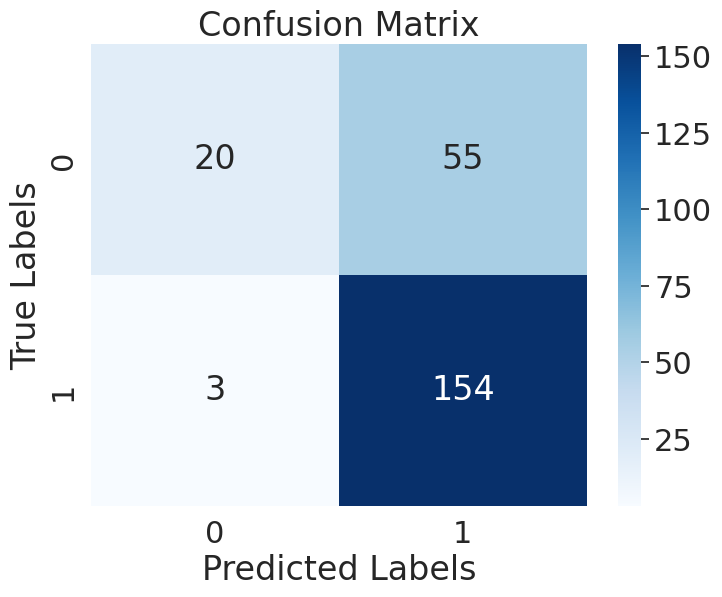

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cms[1], annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
'''
# Save the entire model (architecture, optimizer state, and weights)
model.save('trained_model.h5')

# Alternatively, you can save just the weights
model.save_weights('model_weights.h5')

from tensorflow.keras.saving import load_model
# Load the entire model from the .h5 file
loaded_model = load_model('trained_model.h5')
'''


'''
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save("stroke_nihss_1.keras")

# It can be used to reconstruct the model identically.
loaded_model = keras.models.load_model("stroke_nihss_1.keras")

# Summary of the loaded model
loaded_model.summary()
'''

'\n# Calling `save(\'my_model.keras\')` creates a zip archive `my_model.keras`.\nmodel.save("stroke_nihss_1.keras")\n\n# It can be used to reconstruct the model identically.\nloaded_model = keras.models.load_model("stroke_nihss_1.keras")\n\n# Summary of the loaded model\nloaded_model.summary()\n'

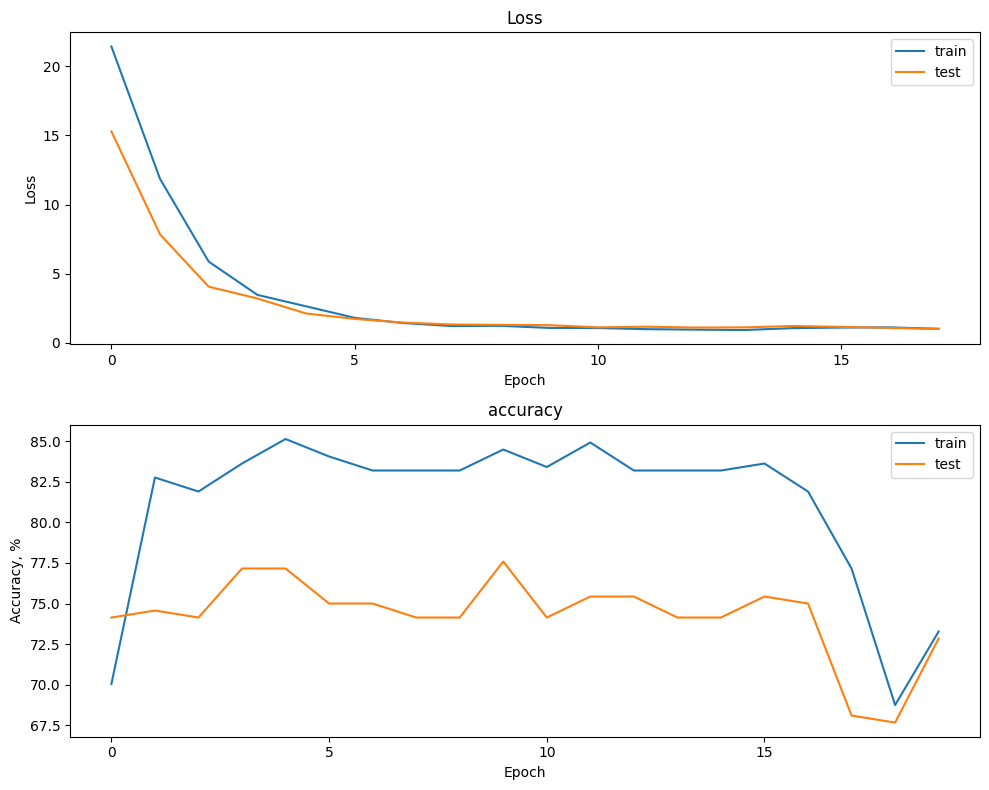

In [ ]:
from matplotlib import pyplot as plt

history = all_history[1]

# Create a larger figure
plt.figure(figsize=(10, 8))

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='test')
plt.legend()
#plt.xticks(range(len(history.history['loss'][2:])))
plt.xticks(range(0, len(history.history['loss'][2:]), 5))  # Show every 5th
plt.xlabel('Epoch')
plt.ylabel('Loss')

# plot accuracy during training
plt.subplot(212)
plt.title('accuracy')
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.plot([acc * 100 for acc in history.history['accuracy']], label='train')
plt.plot([acc * 100 for acc in history.history['val_accuracy']], label='test')
#plt.xticks(range(len(history.history['accuracy'])))
plt.xticks(range(0, len(history.history['accuracy']), 5))  # Show every 5th label
plt.xlabel('Epoch')
plt.ylabel('Accuracy, %')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend()

# Save the figure as an image file
plt.savefig('training_results.png')

plt.show()

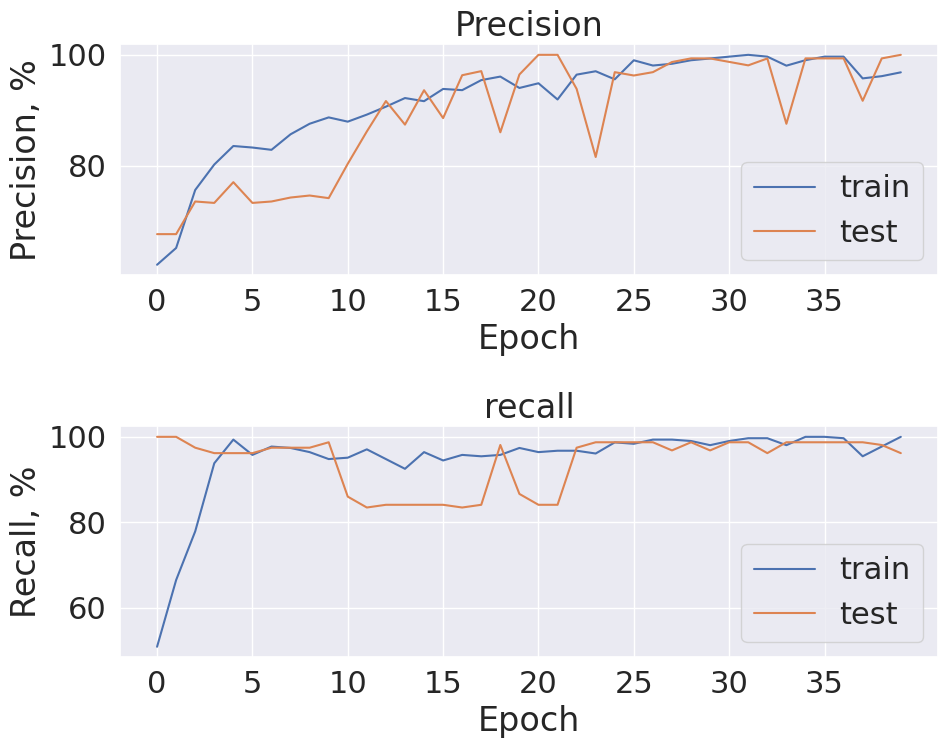

In [ ]:
from matplotlib import pyplot as plt
# Create a larger figure
plt.figure(figsize=(10, 8))

# plot loss during training
plt.subplot(211)
plt.title('Precision')
plt.plot([acc * 100 for acc in history.history['precision']], label='train')
plt.plot([acc * 100 for acc in history.history['val_precision']], label='test')
plt.legend()
plt.xticks(range(0, len(history.history['precision']), 5))  # Show every 5th label
plt.xlabel('Epoch')
plt.ylabel('Precision, %')

# plot accuracy during training
plt.subplot(212)
plt.title('recall')
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.plot([acc * 100 for acc in history.history['recall']], label='train')
plt.plot([acc * 100 for acc in history.history['val_recall']], label='test')
plt.xticks(range(0, len(history.history['recall']), 5))  # Show every 5th label
plt.xlabel('Epoch')
plt.ylabel('Recall, %')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend()

# Save the figure as an image file
#plt.savefig('training_results.png')

plt.show()

In [ ]:
#NEW CODE# Step 1: Make Predictions# Step 2: Convert Probabilities to Classes using a threshold (e.g., 0.5)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


model = all_models[1]
y_pred_prob_test = model.predict(X_test)
threshold = 0.5
Y_test_model = (y_pred_prob_test > threshold).astype(int)

y_pred_prob_train = model.predict(X_train)
threshold = 0.5
Y_train_model = (y_pred_prob_train > threshold).astype(int)

# Convert one-hot encoded to a single column with values 1, 2, 3
'''
Y_train_model = np.argmax(Y_train_model, axis=1)
Y_test_model = np.argmax(Y_test_model, axis=1)
'''

15/15 [==============================] - 1s 35ms/step


'\nY_train_model = np.argmax(Y_train_model, axis=1)\nY_test_model = np.argmax(Y_test_model, axis=1)\n'

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_short, Y_test_model))

              precision    recall  f1-score   support

           0       1.00      0.41      0.58       120
           1       0.61      1.00      0.76       112

    accuracy                           0.69       232
   macro avg       0.81      0.70      0.67       232
weighted avg       0.81      0.69      0.67       232



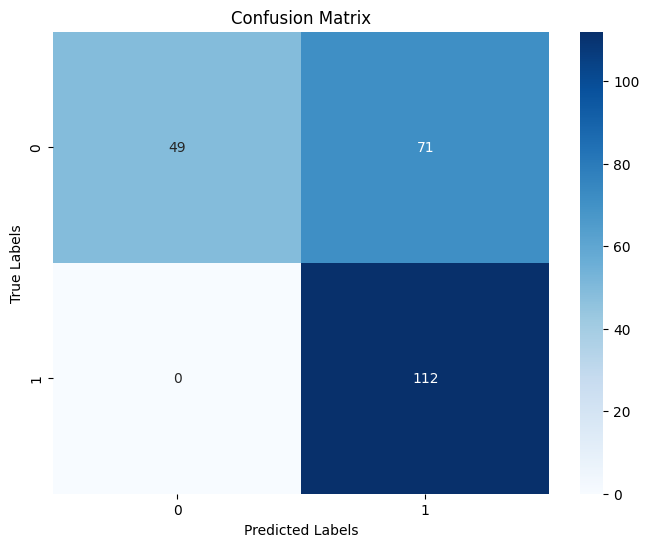

In [ ]:
# Step 3: Calculate Confusion Matrix
conf_matrix = confusion_matrix(Y_test_short, Y_test_model)

# Step 4: Visualize Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Predict outputs and save them in a variable
'''Y_train_model = model.predict(X_train)
Y_test_model = model.predict(X_test)'''


'Y_train_model = model.predict(X_train)\nY_test_model = model.predict(X_test)'

In [ ]:
#Y_train_model

In [ ]:

# Cast the float array to an integer array
# Create a pandas Series from the array
'''y_pred = (Y_train_model > threshold).astype(int)
y_pred = (Y_test_model > threshold).astype(int)
Y_train_model = pd.Series(Y_train_model.astype(int).flatten())
Y_test_model  = pd.Series(Y_test_model.astype(int).flatten())'''

'y_pred = (Y_train_model > threshold).astype(int)\ny_pred = (Y_test_model > threshold).astype(int)\nY_train_model = pd.Series(Y_train_model.astype(int).flatten())\nY_test_model  = pd.Series(Y_test_model.astype(int).flatten())'

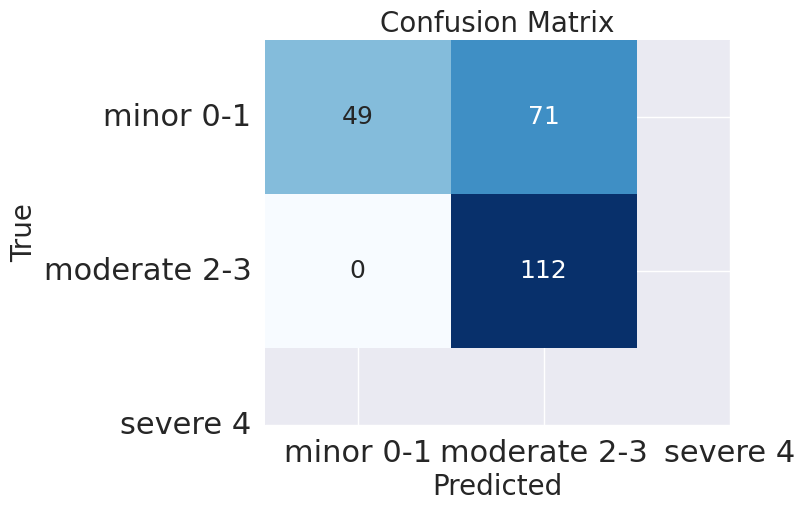

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample predicted and true values
#predicted = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1])
#true = np.array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

predicted = Y_test_model
true      = Y_test_short

# Calculate confusion matrix
cm = confusion_matrix(true, predicted)
#cm = [[453629,246371],[165458,284674]]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 5))
#sns.heatmap(cm, annot=True,  cmap="Blues", xticklabels=["minor", "moderate"], yticklabels=["minor", "moderate"]) #fmt="d",

sns.set(font_scale = 2)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=["minor 0-1","moderate 2-3","severe 4"], yticklabels=["minor 0-1","moderate 2-3","severe 4"], cbar=False, annot_kws={"size": 18}) #fmt="d",
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)


# Save the figure as an image file
plt.savefig('confusion_matrix.png')

plt.show()

In [ ]:
Y_train_model = pd.Series(Y_train_model.astype(int).flatten())
Y_test_model  = pd.Series(Y_test_model.astype(int).flatten())

In [ ]:
Y_train_model.value_counts(normalize=False)

0    464
dtype: int64

In [ ]:
Y_test_model.value_counts(normalize=False)

0    232
dtype: int64

In [ ]:
#Y_train_short.value_counts(normalize=False)

In [ ]:
#Y_test_short.value_counts(normalize=False)

8/8 [==============================] - 0s 53ms/step


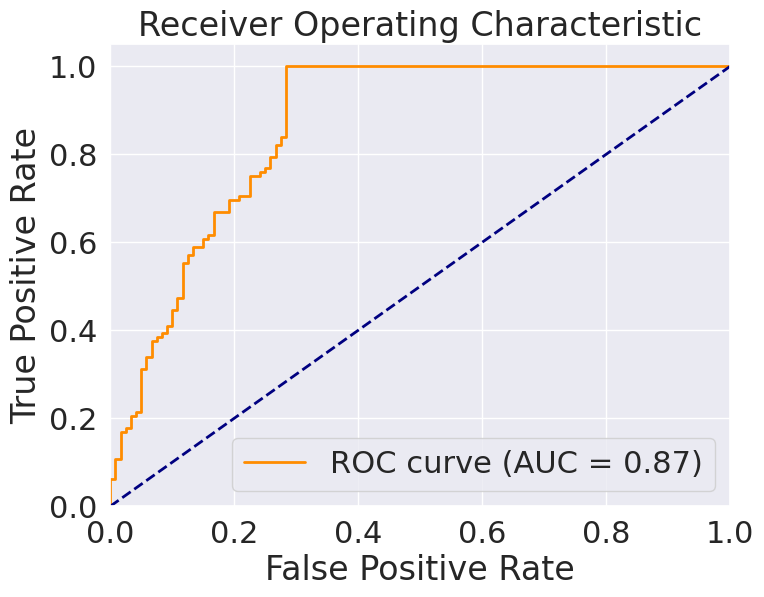

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


model = all_models[2]
# Step 1: Make Predictions
y_pred_prob = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_short, y_pred_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
'''
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make Predictions
y_pred_prob = model.predict(X_test)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
NUM_CLASSES = 3

for i in range(NUM_CLASSES):  # Replace NUM_CLASSES with the actual number of classes
    fpr[i], tpr[i], _ = roc_curve(Y_test_short[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']  # Customize colors for each class
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
'''

"\nimport numpy as np\nfrom sklearn.metrics import roc_curve, auc\nimport matplotlib.pyplot as plt\n\n# Step 1: Make Predictions\ny_pred_prob = model.predict(X_test)\n\n# Calculate ROC curve and AUC for each class\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nNUM_CLASSES = 3\n\nfor i in range(NUM_CLASSES):  # Replace NUM_CLASSES with the actual number of classes\n    fpr[i], tpr[i], _ = roc_curve(Y_test_short[:, i], y_pred_prob[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\n# Plot ROC curves\nplt.figure(figsize=(8, 6))\ncolors = ['darkorange', 'green', 'blue']  # Customize colors for each class\nfor i, color in zip(range(NUM_CLASSES), colors):\n    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class %d (AUC = %0.2f)' % (i, roc_auc[i]))\n\nplt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('Receiver Operating Characteristic')\nplt.leg